<a href="https://colab.research.google.com/github/medinadiegoeverardo/DS-Unit-2-Applied-Modeling/blob/master/module2/re_medinadiego_2_assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df = pd.read_csv('/content/gdrive/My Drive/AB_NYC_2019.csv')

In [0]:
df.shape

(48895, 16)

In [0]:
cutoff = '2018-09-07'
new_df = df[df['last_review'] > cutoff]
# splitting for test, train and val

In [0]:
new_df.shape

(27908, 16)

In [0]:
sorted_df = new_df.sort_values(by='last_review').reset_index() # sort by earliest to most recent

In [0]:
train = sorted_df[sorted_df.index < (0.85 * len(sorted_df))] # give me the indices that less than 23721
test = sorted_df[sorted_df.index > (.85 * len(sorted_df))] # give me those "above" 23721

In [0]:
test.shape, train.shape

((4186, 17), (23722, 17))

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, random_state=10)

# even though I randomly split train to have a train and val set, the train/test
# split is not random. the test set has more recent data

In [0]:
train.shape, val.shape

((17791, 17), (5931, 17))

In [0]:
train = train.copy()
val = val.copy()
test = test.copy()

def separating_date(df):
  df['month'] = df['last_review'].dt.month
  df['year'] = df['last_review'].dt.year
  df['day'] = df['last_review'].dt.day

separating_date(train)
separating_date(val)
separating_date(test)

In [0]:
import numpy as np
train = train.copy()
test = test.copy()
val = val.copy()
train['log_price'] = np.log1p(train['price'])
val['log_price'] = np.log1p(val['price'])
test['log_price'] = np.log1p(test['price'])

In [0]:
print(train.shape)
train.head()

(17791, 18)


,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price
22246,45511,34804749,Cozy East Village Studio - Backyard Space,81351940,Rick,Manhattan,East Village,40.72387,-73.97845,Entire home/apt,166,2,4,2019-06-30,2.79,1,75,5.117994
12234,35996,28606376,Bedroom Apartment in the Heart of Manhattan,215897007,Joana,Manhattan,Murray Hill,40.74536,-73.97506,Private room,355,2,13,2019-06-09,1.49,1,308,5.874931
16976,14288,11100490,Massive 3 bedroom with Patio,57648603,Shpresa,Manhattan,Gramercy,40.73562,-73.98756,Entire home/apt,500,4,49,2019-06-22,1.23,1,249,6.216606
14470,44835,34419723,420 + Sunny! Private room w/balcony,34356520,Jacquelyn,Queens,Ridgewood,40.71104,-73.90303,Private room,65,2,7,2019-06-16,4.04,1,104,4.189655
17094,38907,30437968,Beautiful one bed in the best part of Brooklyn,52575295,Jonny,Brooklyn,Williamsburg,40.71972,-73.95705,Entire home/apt,295,5,3,2019-06-22,0.49,1,46,5.690359


In [0]:
print(test.shape)
test.head()

(4186, 18)


,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price
23722,17457,13749474,The Brooklyn RedStone,40507839,Terrie,Brooklyn,Bedford-Stuyvesant,40.68574,-73.92975,Entire home/apt,118,3,20,2019-07-01,3.21,1,33,4.779123
23723,37981,30020090,Large Chic Uptown NYC Apartment,225646557,Mike,Manhattan,Washington Heights,40.83901,-73.93802,Entire home/apt,199,2,18,2019-07-01,2.56,1,171,5.298317
23724,45155,34569042,4 Rooms 3 Bedroom Pre War Central Park West Co...,26935678,Zach,Manhattan,Upper West Side,40.80032,-73.95998,Entire home/apt,285,1,9,2019-07-01,5.09,1,229,5.655992
23725,45156,34569454,Surf-N-Sleep By the Sea Studio,260842282,Andy,Queens,Arverne,40.59269,-73.79635,Entire home/apt,95,2,6,2019-07-01,3.46,1,348,4.564348
23726,36602,29101869,Sunny apartment with piano + yard!,161873557,Natalia,Brooklyn,Bedford-Stuyvesant,40.69898,-73.94705,Entire home/apt,85,3,34,2019-07-01,4.36,1,42,4.454347


In [0]:
print(val.shape)
val.head()

(5931, 18)


,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price
17522,20214,16172073,Sunny renovated 1 BR in Brooklyn by Prospect Park,105572605,Peter,Brooklyn,Flatbush,40.64745,-73.96207,Entire home/apt,72,1,15,2019-06-23,3.13,1,1,4.290459
5248,3896,2404708,Williamsburg 1 bedroom appartement,12290324,Lara,Brooklyn,Williamsburg,40.71952,-73.96281,Entire home/apt,250,5,21,2019-03-28,0.35,1,284,5.525453
19274,21042,16677866,Nice Private Studio Apartment,107296819,Alexandra,Manhattan,East Harlem,40.79747,-73.93559,Entire home/apt,105,1,124,2019-06-24,4.18,3,0,4.663439
10400,20829,16497297,Glass factory loft,5379884,Jacob,Brooklyn,Greenpoint,40.73792,-73.95541,Private room,60,7,5,2019-05-31,0.16,1,0,4.110874
9754,2829,1586641,SALE- SUNNY MASTER BEDROOM NEAR MANHATTAN,8452639,C S,Brooklyn,Flatbush,40.64919,-73.96143,Private room,84,2,68,2019-05-27,0.96,3,362,4.442651


In [0]:
# to_drop = ['index', 'id', 'name', 'host_id', 'host_name', 'last_review', 'price', 'log_price']
# train = train.drop(columns=to_drop)
# val = val.drop(columns=to_drop)
# test = test.drop(columns=to_drop)

In [0]:
features = ['neighbourhood_group', 'neighbourhood', 'latitude',
 'longitude',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [0]:
target = 'log_price'
y_train = train[target]
y_test = test[target]
y_val = val[target]

x_train = train[features]
x_val = val[features]
x_test = test[features]

In [0]:
!pip install category_encoders

     |████████████████████████████████| 102kB 8.2MB/s 


In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(n_estimators=10, random_state=10)
)

pipeline.fit(x_train, y_train)
# print('Validation Accuracy', pipeline.score(x_val, y_val)) # is accuracy is a good metric in this case?

In [0]:
# mae and r2 scores
from sklearn.model_selection import cross_validate
full_scores = cross_validate(pipeline, x_train, y_train,
                                  scoring=['neg_mean_absolute_error', 'r2'],
                                  cv=3)

In [0]:
full_scores

{'fit_time': array([0.69163227, 0.66594052, 0.66634297]),
 'score_time': array([0.06265783, 0.04925203, 0.05259728]),
 'test_neg_mean_absolute_error': array([-0.30718882, -0.31302327, -0.31768537]),
 'test_r2': array([0.60208099, 0.58515729, 0.58539411])}

In [0]:
scores = cross_val_score(pipeline, x_train, y_train,
                                  scoring='neg_mean_absolute_error',
                                  cv=3)

In [0]:
-scores

array([0.30718882, 0.31302327, 0.31768537])

In [0]:
scores_r2 = cross_val_score(pipeline, x_train, y_train,
                                  scoring='r2',
                                  cv=3)

In [0]:
scores_r2

array([0.60208099, 0.58515729, 0.58539411])

In [0]:
pd.Series(pipeline.named_steps['randomforestregressor'].feature_importances_, index=features)

neighbourhood_group               0.040131
neighbourhood                     0.026836
latitude                          0.113048
longitude                         0.126780
room_type                         0.423149
minimum_nights                    0.045708
number_of_reviews                 0.053620
reviews_per_month                 0.064698
calculated_host_listings_count    0.026598
availability_365                  0.079432
dtype: float64

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 9.6MB/s 


In [0]:
pipeline_transformer = make_pipeline(
    ce.OrdinalEncoder(),
    ce.OneHotEncoder(use_cat_names=True),
    #SimpleImputer(strategy='median')
)

x_train_transformed = pipeline_transformer.fit_transform(x_train)
x_val_transformed = pipeline_transformer.transform(x_val)

model = RandomForestRegressor(n_estimators=100, random_state=10, n_jobs=-1)
model.fit(x_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, # error because I was putting this: pipeline_transformer
    scoring='r2', 
    n_iter=5, 
    random_state=10
)

permuter.fit(x_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [0]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=features
)

Weight,Feature
0.7458 ± 0.0302,room_type
0.2101 ± 0.0160,longitude
0.1256 ± 0.0082,latitude
0.0862 ± 0.0089,availability_365
0.0826 ± 0.0039,minimum_nights
0.0720 ± 0.0069,neighbourhood_group
0.0282 ± 0.0033,calculated_host_listings_count
0.0216 ± 0.0027,number_of_reviews
0.0195 ± 0.0023,reviews_per_month
0.0080 ± 0.0011,neighbourhood


### boosting

In [0]:
encoder = ce.OneHotEncoder()
x_train_encoded = encoder.fit_transform(x_train)
x_val_encoded = encoder.transform(x_val)

eval_set = [(x_train_encoded, y_train), 
            (x_val_encoded, y_val)]

In [0]:
model = XGBRegressor(
    n_estimators=200, # <= 1000 trees, depends on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.1, # try higher learning rate
    n_jobs=-1
)

model.fit(x_train_encoded, y_train, eval_set=eval_set, early_stopping_rounds=30) # eval_metric='neg_mean_absolute_error'

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:22:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.84872	validation_1-rmse:3.83302
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:3.46939	validation_1-rmse:3.45459
[2]	validation_0-rmse:3.12845	validation_1-rmse:3.11437
[3]	validation_0-rmse:2.82212	validation_1-rmse:2.80879
[4]	validation_0-rmse:2.54698	validation_1-rmse:2.53449
[5]	validation_0-rmse:2.29992	validation_1-rmse:2.28813
[6]	validation_0-rmse:2.07827	validation_1-rmse:2.0674
[7]	validation_0-rmse:1.87943	validation_1-rmse:1.86934
[8]	validation_0-rmse:1.70124	validation_1-rmse:1.69166
[9]	validation_0-rmse:1.54168	validation_1-rmse:1.53295
[10]	validation_0-rmse:1.39894	validation_1-rmse:1.39115
[11]	validation_0-rmse:1.27139	validation_1-rmse:1.26422
[12]	validation_0-rmse:1.15756	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

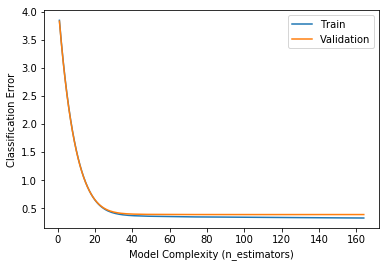

In [0]:
import matplotlib.pyplot as plt

results = model.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend(); 

In [0]:
# ['neg_mean_squared_error'] # how do you use this eval metric?

# exmaple I saw online

# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.30, random_state=1)
# xgb_model = xgb.XGBRegressor(n_estimators=600, learning_rate=0.06)

# fit_params={'early_stopping_rounds': 30, 
#             'eval_metric': 'mae',
#             'verbose': False,
#             'eval_set': [[val_x, val_y]]}

# xgb_cv = cross_val_score(xgb_model, train_x, train_y, 
#                          cv = 5, 
#                          scoring = 'neg_mean_absolute_error',
#                          fit_params = fit_params)